In [12]:
import asyncio

import numpy as np
import sep
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.images.processors.background import DaophotBackground, SepBackground
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries


In [13]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wd

from astropy.table import QTable
from photutils.datasets import make_gaussian_sources_image

from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.io import fits



In [14]:
from os.path import basename

class FitsDisplay:
    
    def __init__(self):
        
        self.fig = plt.figure(constrained_layout=True)
#        self.fig = plt.figure(tight_layout=True)
        self.fig.suptitle('none')
        self.fig.canvas.header_visible = False
#        self.fig.canvas.footer_visible = False
#        self.fig.canvas.resizable = False
        
        self.axes = None

    def draw_image(self, image, filename:str=""):
        if not self.axes:
            wcs = WCS(image.header)
            self.axes = self.fig.add_subplot(1, 1, 1, projection=wcs)

        mean, sigma, min, max = np.mean(image.data), np.std(image.data), np.min(image.data), np.max(image.data)
        lperc, uperc = np.percentile(image.data, 5), np.percentile(image.data, 99.5)
        median = np.median(image.data)

        self.axes.imshow(
                image.data, 
                origin='lower',
                norm=PowerNorm(1.4,
                               vmin=median,
                               vmax=uperc,
                               clip=True,
                              )
#                norm=LogNorm(vmin=50, vmax=1000)
            )
        self.axes.scatter([image.data.shape[1]/2], [image.data.shape[0]/2], marker='+', s=40, color='red')
        self.fig.suptitle(f'{image.header["CAMNAME"]} {filename}')
        self.fig.canvas.draw_idle()



In [18]:
from lvmtipo.actors import lvm

telescope = "skye"
tel = await lvm.from_string(telescope).start()
await tel.agc.status()

cam_list = (await tel.agc.status()).keys()
cam_dict = dict(zip(cam_list, range(len(cam_list))))


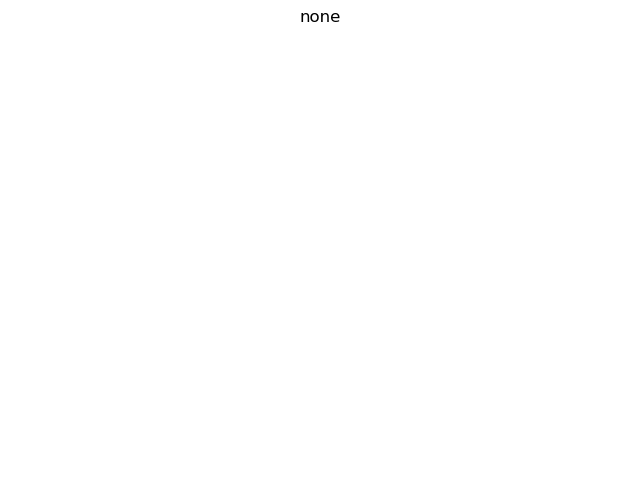

In [19]:
import asyncio, time
import ipywidgets as wd

output = wd.Textarea(layout=wd.Layout(height="auto", width="auto"))
running = wd.ToggleButton(description="start", icon="play")
exptime = wd.FloatSlider(description="", value=1, min=0.01, max=40)
cameras = wd.ToggleButtons(options=cam_list)

ui = wd.VBox([wd.HBox([running, exptime, cameras]), output])
fd = FitsDisplay()

tasks = dict()
camera_current = 0
images = None

async def do_expose():
    while running.value:
        filenames = (await tel.agc.expose(exptime.value)).flatten().unpack("*.filename")
        images = [Image.from_file(f) for f in filenames]
        fd.draw_image(images[camera_current], filename=basename(filenames[camera_current]))
        output.value = f"{filenames} {camera_current}"

def on_camera_changed(change):
    global camera_current
    camera_current = cam_dict[change.new]
    output.value = f"{camera_current}"

def on_running_changed(*change):
    task = tasks.pop("do_expose", None)
#    if task:
#        output.value = f"cancel..."
    if running.value:
        output.value = "starting..."
        tasks["do_expose"] = asyncio.get_event_loop().create_task(do_expose())

running.observe(on_running_changed, "value")
cameras.observe(on_camera_changed, "value")

display(ui)


NameError: name 'cd' is not defined

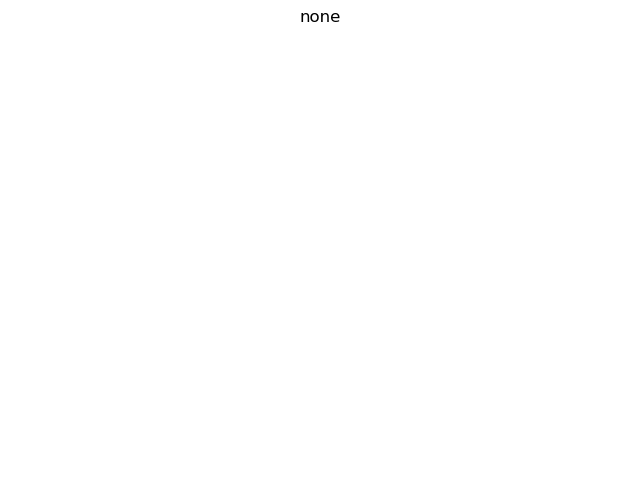

In [17]:
import asyncio, time
import ipywidgets as wd

class CameraDisplay:
    def __init__(self, cam_list):
        self.output = wd.Textarea(layout=wd.Layout(height="auto", width="auto"))
        self.running = wd.ToggleButton(description="start", icon="play")
        self.exptime = wd.FloatSlider(description="", value=1, min=0.01, max=40)
        self.cameras = wd.ToggleButtons(options=cam_list)

        self.ui = wd.VBox([wd.HBox([self.running, self.exptime, self.cameras]), self.output])
        self.fd = FitsDisplay()

        self.tasks = dict()
        self.camera_current = 0
        self.running.observe(self.on_running_changed, "value")
        self.cameras.observe(self.on_camera_changed, "value")
        
        self.cam_dict = dict(zip(cam_list, range(len(cam_list))))

        display(cd.ui)
        self.fd = FitsDisplay()
    async def do_expose(self):
        while running.value:
            filenames = (await tel.agc.expose(self.exptime.value)).flatten().unpack("*.filename")
            images = [Image.from_file(f) for f in filenames]
            fd.draw_image(images[self.camera_current], filename=basename(filenames[self.camera_current]))
            self.output.value = f"{filenames} {self.camera_current}"

    def on_camera_changed(self, change):
        self.camera_current = self.cam_dict[change.new]
        self.output.value = f"{self.camera_current}"
        

    def on_running_changed(self, *change):
        task = self.tasks.pop("do_expose", None)
    #    if task:
    #        output.value = f"cancel..."
        if self.running.value:
             self.output.value = "starting..."
             tasks["do_expose"] = asyncio.get_event_loop().create_task(self.do_expose())
        self.output.value = f"started"

cd = CameraDisplay(cam_list)

